## 3-period-lived Agents with Exogenous Labor Supply

In [3]:
# The essentials
import numpy as np
import scipy as sp
import sympy as sy
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy.linalg as lin

Use the following parameterization of the model for the problems below. Because agents live
for only three periods, assume that each period of life is 20 years. If the annual discount
factor is estimated to be 0.96, then the 20-year discount factor is $\beta = 0.96^{20} = 0.442.$
Let the annual depreciation rate of capital be 0.05. Then the 20-year depreciation rate is
$\delta = 1 − (1 − 0.05)20 = 0.6415.$ Let the coefficient of relative risk aversion be $\sigma = 3$, let
the productivity scale parameter of firms be A = 1, and let the capital share of income be
$\alpha = 0.35.$

The parameter block is activated below.

### Parameters

In [4]:
#Pass of parameters
beta = .442; delta = .6415; sigma = 3; alpha = .35; A = 1
nvec = np.array([1.0, 1.0, .2])
L = 1
SS_tol = .005

In [5]:
f_params = nvec, A, alpha, delta #define f parama

### Prices (wage)

In [6]:
def get_w(K, w_args):
    '''To get wages as a function of capital and parameters.'''
    A, alpha = w_args
    
    w = (1 - alpha) * A * (((K) / (L)) ** alpha)
    
    return w

### Prices (Rental Rate)

In [ ]:
def get_r(K, r_args):
    '''To get rental rate as a function of capital and parameters.'''
    A, alpha, delta = r_args
    
    r = alpha * A * (((L) / (K)) ** (1 - alpha)) - delta
    
    return r

### Exercise 2.1 (Verifying non-negativity constraints)

In [7]:
def nngev(f_params, bvec_guess):
    '''Implements the verification for non negativity
    '''
    b2, b3 = bvec_guess
    nvec, A, alpha, delta = f_params
    
    K_cnstr, c_cnstr, b_cnstr = np.full(1, False), np.full(3, False), np.full(2, False)
    
    w_args = A, alpha
    r_args = A, alpha, delta
    w = get_w(b2 + b3, w_args)
    r = get_r(b2 + b3, r_args)
    
    c_cnstr[0] = nvec[0] * w - b2 < 0 
    c_cnstr[1] = nvec[1] * w + (1 + r) * b2 - b3 < 0
    c_cnstr[2] = nvec[2] * w + (1 + r) * b3 < 0
    
    
    K_cnstr[0] = b2 + b3 < 0
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
        
    return b_cnstr, c_cnstr, K_cnstr

#### Exercise 2.1 (a)

In [9]:
bvec_guess1 = np.array([1.0, 1.2])
nngev(f_params, bvec_guess1)

(array([ True, False]), array([ True, False, False]), array([False]))

Excessive savings in period 1 leading to negative consumption. 

#### Exercise 2.1 (b)

In [11]:
bvec_guess2 = np.array([0.06, -.001]) #Possibe variation
nngev(f_params, bvec_guess2)

(array([False, False]), array([False, False, False]), array([False]))

No violation reported here.

#### Exercise 2.1 (c)

In [13]:
bvec_guess3 = np.array([0.1, 0.1])
nngev(f_params, bvec_guess3)

(array([False, False]), array([False, False, False]), array([False]))

No violation reported here.

### Steady State Eqm of the OLG model

In [14]:
def Euler_error(bvec, *err_args):
    '''To back out Euler errors
    '''
    beta, sigma, A, alpha, delta = err_args
    b2, b3 = bvec
    w_args = A, alpha
    r_args = A, alpha, delta
    w = get_w(b2 + b3, w_args) 
    r = get_r(b2 + b3, r_args) 
    c1 = w - b2
    c2 = w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + 0.2 * w
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    err1 = MU1 - beta * (1 + r) * MU2
    err2 = MU2 - beta * (1 + r) * MU3
    
    return err1, err2

In [23]:
def get_SS(params, bvec_guess, SS_graphs):
    '''This function solves for the steady-state equilibrium.
    '''
    
    start_time = time.clock()
    b2, b3 = bvec_guess
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    err_args = beta, sigma, A, alpha, delta
    w_args = A, alpha
    r_args = A, alpha, delta
    results_ss = opt.root(Euler_error, bvec_guess, tol=SS_tol, args=(err_args))
    b_ss = results_ss.x
    w_ss = get_w(sum(b_ss), w_args)
    r_ss = get_r(sum(b_ss), r_args)
    c_ss = np.array([w_ss - b_ss[0], 
                     w_ss + (1 + r_ss)*b_ss[0] - b_ss[1],
                     (1 + r_ss)*b_ss[1] + .2 * w_ss])
    K_ss = np.sum(b_ss)
    Y_ss = A * (K_ss ** alpha) * (L ** (1 - alpha))
    C_ss = Y_ss - K_ss + (1 - delta) * K_ss
    
    EulErr_ss = np.array([beta * (1 + r_ss) * (c_ss[1] ** -sigma) - (c_ss[0] ** -sigma),
                          beta * (1 + r_ss) * (c_ss[2] ** -sigma) - (c_ss[1] ** -sigma)])
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock()
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss, 
        'ss_time': ss_time}
    if SS_graphs == True:
        fig, ax = plt.subplots(figsize=(6,6))
        s = np.array([1, 2, 3])
        plt.plot(s, c_ss, label=r'$\bar{c}_s$', marker='*')
        plt.plot(s[1:], b_ss, label=r'$\bar{b}_s$', marker='*')
        plt.title("Steady-State Consumption and Savings")
        plt.legend()
        plt.grid()
        plt.xlabel("Age (s)")
        plt.ylabel("Level")
        plt.xticks(s)
        plt.show()
        
    return ss_output

In [24]:
params = beta, sigma, nvec, L, A, alpha, delta, SS_tol

C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


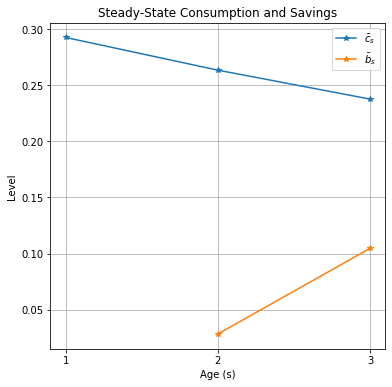

{'b_ss': array([0.02846247, 0.10470894]), 'c_ss': array([0.29250218, 0.26339752, 0.2376202 ]), 'w_ss': 0.3209646551886283, 'r_ss': 0.6562794340316018, 'K_ss': 0.13317141379544897, 'Y_ss': 0.49379177721327433, 'C_ss': 0.4083623152634938, 'EulErr_ss': array([ 0.10209282, -0.15842775]), 'RCerr_ss': 0.0, 'ss_time': 4898.545000388}
Wall time: 4.52 s


In [25]:
%%time
results_ss = get_SS(params, np.array([.1, .1]), True)
print(results_ss)

As shown above, computing the steady-state was almost instant.

C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


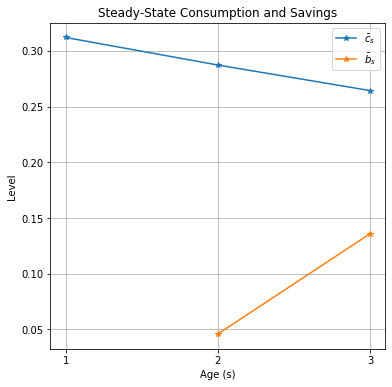

{'b_ss': array([0.0459699, 0.135901 ]),
 'c_ss': array([0.31198679, 0.28725459, 0.26433907]),
 'w_ss': 0.35795669200985963,
 'r_ss': 0.41829519714475105,
 'K_ss': 0.18187090449316887,
 'Y_ss': 0.5507026030920917,
 'C_ss': 0.4340324178597239,
 'EulErr_ss': array([-0.01993416,  0.04336155]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': 4902.718420751}

In [26]:
beta1 = .55
params1 = beta1, sigma, nvec, L, A, alpha, delta, SS_tol
results_ss = get_SS(params1, np.array([.1, .1]), True)
results_ss

Standard explanation goes here. When $\beta$ increases, the steady-state levels of savings and consumption both increase (in all ages),  wage increases, and the interest rate decreases. An increase of $\beta$ can be interpreted as the agents becoming more patient. Thus, the increase in savings follows from this intuition. Increased savings leads to an increase in production in future periods, and thus an increase in consumption. The increase in production leads to an increase in wage and a decrease in the interest rate.

### Exercise 2.3: Time Path Iteration (TPI)

In [27]:
# Set additional parameters needed for TPI
T = 25
path_tol = 1e-9
xi = .8
maxIter = 1000

# Solve for SS savings
results_ss = get_SS(params, np.array([.1, .1]), False)
b2bar, b3bar = results_ss['b_ss']

# Guess initial path of aggregate capital 
b21 = .8 * b2bar
b31 = 1.1 * b3bar
K1 = b21 + b31
Kbar = b2bar + b3bar
# Initial guess is a linear capital series
Kpath = np.linspace(K1, Kbar, T)
# Add an extra element to make time indices line up 
Kpath = np.append(Kpath, Kbar)

# Get initial wage and interest rate paths
w_args = A, alpha
r_args = A, alpha, delta
rpath = get_r(Kpath, r_args)
wpath = get_w(Kpath, w_args)
rbar = get_r(Kbar, r_args)
wbar = get_w(Kbar, w_args)
# Add an extra element to make time indices line up (add ss interest rate and wage)
rpath = np.append(rpath, rbar)
wpath = np.append(wpath, wbar)

C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [28]:
def eul_b32(b32, *err1_args):
    """ Solve for b32 using only one intertemporal Euler Equation.
    
    Parameters:
       b32: (float) a guess for the savings vector
             that satisfies the intertemporal Euler equation
       err1_args: a tuple with the model parameters  beta, sigma, rpath, wpath, nvec
        
    Returns:
       err: (float) error in intertemporal Euler equation from using b32
    """
    beta, sigma, rpath, wpath, nvec, b21 = err1_args
    
    # Calculate consumption in each period from budget constraints
    c1 = wpath[0] * nvec[1] + (1 + rpath[0]) * b21 - b32
    c2 = (1 + rpath[1]) * b32 + nvec[2] * wpath[1]
    
    # Calculate marginal utility of consumption
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    
    # Calculate error from intertemporal Euler Equation
    err = MU1 - beta * (1 + rpath[1]) * MU2
    
    return err
    
def eul_b2t_b3t1(bvec, *err2_args):
    """Solve for b_{2,t} and b_{3,t+1} for t=3,...,T+1 using two
    intertemporal Euler Equations.
    
    Parameters:
        bvec: a 2 element numpy array with a guess for the savings vector
        that satisfies the intertemporal Euler equations
        err2_args: a tuple with the model parameters beta, sigma, rpath, wpath, nvec
        
    Returns:
        err1: (float) error in intertemporal Euler equation from using bvec
        err2: (float) error in intertemporal Euler equation from using bvec
    
    """
    
    # rpath has two elements: r_2 and r_3
    # wpath has three elements: w_1, w_2, and w_3
    beta, sigma, rpath, wpath, nvec = err2_args 
    
    # Calculate consumption in each period from budget constraints
    c1 = nvec[0] * wpath[0] - bvec[0]
    c2 = nvec[1] * wpath[1] + (1 + rpath[0]) * bvec[0] - bvec[1]
    c3 = (1 + rpath[1]) * bvec[1] + nvec[2] * wpath[2]
    
    # Calculate marginal utility of consumption
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU3 = c3 ** (-sigma)
    
    # Calculate error from intertemporal Euler Equations
    err1 = MU1 - beta * (1 + rpath[0]) * MU2
    err2 = MU2 - beta * (1 + rpath[1]) * MU3
    
    return err1, err2

In [29]:
eps = path_tol + 1
it = 1
bvec_guess = np.array([.1, .1])

# Solve for time-path equilibrium of aggregate capital
while (it < maxIter and eps > path_tol):
    bmat = np.zeros((T+1,2))
    EulErrs = np.zeros((T+1, 2))
    
    bmat[0,0] = b21
    bmat[0,1] = b31
    
    # Solve for b32
    err1_args = beta, sigma, rpath[:2], wpath[:2], nvec, b21
    result1 = opt.root(eul_b32, bmat[0,1], args=(err1_args))
    bmat[1,1] = result1.x
    EulErrs[1,1] = result1.fun
    
    # Solve for b_{2,t} and b_{3,t+1} using the twisted donut method
    for tt in range(1,T):
        # Solve for b_{2,t} and b_{3,t+1}
        err2_args = beta, sigma, rpath[tt:tt+2], wpath[tt-1:tt+2], nvec
        result2 = opt.root(eul_b2t_b3t1, bvec_guess, args=(err2_args))
        bmat[tt,0] = result2.x[0]
        bmat[tt+1,1] = result2.x[1]
        EulErrs[tt,0] = result2.fun[0]
        EulErrs[tt+1,1] = result2.fun[1]
    
    # Calculate maximum of the absolute values of all the Euler 
    # errors across the entire time path.
    max_AbsEulErrs = np.abs(EulErrs).max(axis = 0)
    
    # Calculate new aggregate capital levels
    Kpath_prime = bmat[:-1].sum(axis=1)
    Kpath_prime = np.append(Kpath_prime, Kbar)
    
    # Calculate difference from last capital series (using L2 norm)
    eps = lin.norm(Kpath_prime - Kpath, 2)
    
    # Update capital series
    Kpath_new = xi * Kpath_prime + (1 - xi) * Kpath
    Kpath = np.copy(Kpath_new)
    
    # Update interest rates and wages
    rpath = get_r(Kpath, r_args)
    wpath = get_w(Kpath, w_args)
    
    it = it + 1 

#### Maximum of the absolute values of all the Euler errors across the entire time path

In [30]:
print(max_AbsEulErrs)

[1.14511067e-10 2.33846720e-10]


#### Maximum of the absolute value of all the aggregate resource constraint errors

In [31]:
Yt = A * (Kpath[:-1] ** alpha) * (L **(1 - alpha))
Ct = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
agg_RC_Err = Yt - Ct - Kpath[1:] + (1 - delta) * Kpath[:-1]
max_agg_RC_Err = np.abs(agg_RC_Err).max()
print(max_agg_RC_Err)

0.028505893073381812


#### Plot Equilibrium Time Paths of Aggregate Capital Stocks, Wage, and Interest Rate

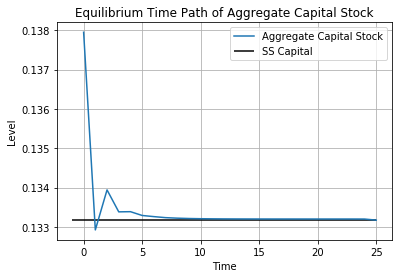

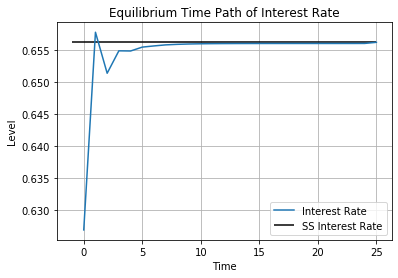

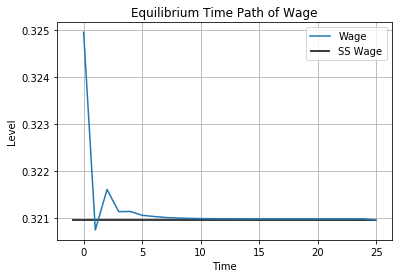

In [32]:
plt.plot(Kpath, label='Aggregate Capital Stock')
plt.hlines(Kbar, -1, T, label='SS Capital')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Aggregate Capital Stock')
plt.legend()
plt.show()

plt.plot(rpath, label='Interest Rate')
plt.hlines(rbar, -1, T, label='SS Interest Rate')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Interest Rate')
plt.legend()
plt.show()

plt.plot(wpath, label='Wage')
plt.hlines(wbar, -1, T, label='SS Wage')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Equilibrium Time Path of Wage')
plt.legend()
plt.show()

#### How many periods did it take for the economy to get within 0.00001 of the steady-state aggregate capital stock $\bar{K}$?

In [33]:
Kpath_dist_ss = np.abs(Kpath - Kbar)
err =  .00001
# Find first period where capital got within 0.00001 of the steady-state aggregate capital stock 
firstLoc = np.where(Kpath_dist_ss < err)[0]
firstLoc[0]

25

#### What is the period after which the aggregate capital stock never is again farther than 0.00001 away from the steady-state?

In [34]:
loc_cons = np.ediff1d(firstLoc) == 1
firstLoc[-len(loc_cons)]

25